In [1]:
import os
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import nibabel
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
import cv2
from skimage.filters import unsharp_mask
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight
from skimage.transform import resize

/home/uiu/miniconda3/envs/tf_conda/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-04-21 22:42:46.682673: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")

1 Physical GPUs, 1 Logical GPUs


# Resnet18

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Activation, Dense, Flatten, Conv3D, Add, GlobalAveragePooling3D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

# Channel Attention Module for 3D
class ChannelAttention3D(tf.keras.layers.Layer):
    def __init__(self, reduction_ratio=16, **kwargs):
        super(ChannelAttention3D, self).__init__(**kwargs)
        self.reduction_ratio = reduction_ratio

    def build(self, input_shape):
        self.avg_pool = tf.keras.layers.GlobalAveragePooling3D()
        self.max_pool = tf.keras.layers.GlobalMaxPooling3D()
        self.dense1 = tf.keras.layers.Dense(input_shape[-1] // self.reduction_ratio, activation='relu', use_bias=False)
        self.dense2 = tf.keras.layers.Dense(input_shape[-1], activation='sigmoid', use_bias=False)

    def call(self, inputs):
        # Reduce the spatial dimensions to a single number
        avg_pooled = self.avg_pool(inputs)
        max_pooled = self.max_pool(inputs)

        # Pass through the shared dense layers
        avg_out = self.dense1(avg_pooled)
        avg_out = self.dense2(avg_out)
        max_out = self.dense1(max_pooled)
        max_out = self.dense2(max_out)

        # Re-add the spatial dimensions that were reduced by Global Pooling
        out = avg_out + max_out
        scale = tf.reshape(out, [-1, 1, 1, 1, inputs.shape[-1]])  # Reshape to broadcast
        return inputs * scale


# Spatial Attention Module for 3D
class SpatialAttention3D(tf.keras.layers.Layer):
    def __init__(self, kernel_size=7, **kwargs):
        super(SpatialAttention3D, self).__init__(**kwargs)
        self.conv3d = tf.keras.layers.Conv3D(1, kernel_size, padding='same', activation='sigmoid', use_bias=False)

    def call(self, inputs):
        avg_out = tf.reduce_mean(inputs, axis=-1, keepdims=True)
        max_out = tf.reduce_max(inputs, axis=-1, keepdims=True)
        concat = tf.concat([avg_out, max_out], axis=-1)
        out = self.conv3d(concat)
        return inputs * out
def _bn_relu(input):
    norm = BatchNormalization(axis=-1)(input)
    return Activation("relu")(norm)

def _conv_bn_relu3D(filters, kernel_size, strides=(1, 1, 1), padding="same", kernel_initializer="he_normal", kernel_regularizer=l2(1e-4)):
    def f(input):
        conv = Conv3D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, kernel_initializer=kernel_initializer, kernel_regularizer=kernel_regularizer)(input)
        return _bn_relu(conv)
    return f

def basic_block(filters, kernel_regularizer=l2(1e-4), downsample=False):
    def f(input):
        strides = (2, 2, 2) if downsample else (1, 1, 1)
        conv1 = _conv_bn_relu3D(filters, (3, 3, 3), strides=strides)(input)
        attention_layer1 = ChannelAttention3D()(conv1)
        attention_layer1 = SpatialAttention3D()(attention_layer1)
        conv2 = _conv_bn_relu3D(filters, (3, 3, 3))(attention_layer1)

        shortcut = input
        if downsample or input.shape[-1] != filters:
            shortcut = Conv3D(filters, (1, 1, 1), strides=strides, padding="same", kernel_initializer="he_normal", kernel_regularizer=kernel_regularizer)(input)

        return Add()([conv2, shortcut])
    return f

def _residual_block(block_function, filters, repetitions, is_first_layer=False):
    def f(input):
        for i in range(repetitions):
            downsample = (i == 0 and not is_first_layer)
            input = block_function(filters=filters, kernel_regularizer=l2(1e-4), downsample=downsample)(input)
        return input
    return f

def build_resnet_18(input_shape, num_outputs):
    input = Input(shape=input_shape)
    conv1 = _conv_bn_relu3D(filters=64, kernel_size=(7, 7, 7), strides=(2, 2, 2))(input)

    block1 = _residual_block(basic_block, 64, 2, is_first_layer=True)(conv1)
    block2 = _residual_block(basic_block, 128, 2)(block1)
    block3 = _residual_block(basic_block, 256, 2)(block2)
    block4 = _residual_block(basic_block, 512, 2)(block3)

    gap = GlobalAveragePooling3D()(block4)
    dense = Dense(units=num_outputs, activation="softmax")(gap)

    model = Model(inputs=input, outputs=dense)
    return model

# Example to create a model
# model = build_resnet_18(input_shape=(64, 64, 64, 1), num_outputs=2)
# model.summary()


In [5]:
def apply_mask(aseg_image, brain_image, labels = [17, 53, 2, 7, 41, 46]):
    brain_data = aseg_image.get_fdata()
    aseg_data = aseg_image.get_fdata()
    origin_data = brain_image.get_fdata()
    
    brain_mask = np.zeros_like(aseg_data)
    for label in labels:
        brain_mask += np.where((aseg_data == label), 1, 0)

#     segmented_brain_image = brain_data * brain_mask
#     segmented_brain_image = nibabel.Nifti1Image(segmented_brain_image, affine=None)
    new_image = origin_data * brain_mask
    
    return new_image

def enhance_slice(slice_data):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_slice = clahe.apply(slice_data.astype(np.uint8))

    return enhanced_slice

def enhance_image(img_data):
    enhanced_slices = []
    
    for slice_idx in range(img_data.shape[2]):
        slice_data = img_data[:, :, slice_idx]
        enhanced_slice = enhance_slice(slice_data)
        enhanced_slices.append(enhanced_slice)
    enhanced_volume = np.dstack(enhanced_slices)

    return enhanced_volume

def sharpen_image(image, strength=1.0):
    sharpened_image = unsharp_mask(image, radius=1, amount=strength)
    return sharpened_image

In [19]:
from scipy.ndimage import rotate

def augment(image, rotation_range):
    rotation_angle = np.random.uniform(-rotation_range, rotation_range)
    rotated_image = rotate(image, rotation_angle, reshape=False)
    
    return rotated_image

def image_load_nonRoi(image_path, target_shape, type_dt=''):
    asg_img = nibabel.load(image_path).get_fdata()
#     image = nibabel.load(image_path).get_fdata()
    
    origin_path = "/".join(image_path.split('/')[:-1]) + "/orig.mgz"
    origin_image = nibabel.load(origin_path).get_fdata()
    mask = np.where(asg_img != 0, 1, 0)
    
    image = origin_image * mask
    image = enhance_image(image)
    image = sharpen_image(image)
    image = resize(image, target_shape, anti_aliasing=True)
    
    if type_dt=='train':
        image = augment(image, 180)
        
    return image
    
def data_generator(paths, labels, batch_size, target_shape, type_dt=''):
    while True:
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i+batch_size]
            batch_labels = labels[i:i+batch_size]
            batch_images = []
            
            batch_images = [image_load_nonRoi(image, target_shape, type_dt) for image in batch_paths]

            batch_images = np.stack([batch_images] * 1, axis=-1)

            batch_labels = to_categorical(batch_labels, num_classes=2)
            yield np.array(batch_images), batch_labels

In [20]:
# original shape (257, 257, 257)
base_dir = 'adni-1-5t-filtered-preprocessed-quickseg-dataset'
ad = os.path.join(base_dir, 'AD')
mci = os.path.join(base_dir, 'MCI')
cn = os.path.join(base_dir, 'CN')


ad_images= []
mci_images = []
cn_images = []

for subject_dir in os.listdir(ad):
    mri_path = os.path.join(ad, subject_dir, 'mri', 'aparc.DKTatlas+aseg.deep.mgz')
    if not (len(os.listdir(os.path.join(ad, subject_dir, 'mri'))) < 6):
        ad_images.append(mri_path)
        
for subject_dir in os.listdir(mci):
    mri_path = os.path.join(mci, subject_dir, 'mri', 'aparc.DKTatlas+aseg.deep.mgz')
    
    if not (len(os.listdir(os.path.join(mci, subject_dir, 'mri'))) < 6):
        mci_images.append(mri_path)
        
for subject_dir in os.listdir(cn):
    mri_path = os.path.join(cn, subject_dir, 'mri', 'aparc.DKTatlas+aseg.deep.mgz')
    if not (len(os.listdir(os.path.join(cn, subject_dir, 'mri'))) < 6):
        cn_images.append(mri_path)

In [21]:
# image_path = ad_images + mci_images + cn_images
# labels = [0] * len(ad_images) + [1] * len(mci_images) + [2] * len(cn_images)

# image_path = ad_images + mci_images
# labels = [0] * len(ad_images) + [1] * len(mci_images)

image_path = mci_images + cn_images + cn_images[:len(mci_images)-len(cn_images)]
labels = [0] * len(mci_images) + [1] * len(cn_images) + [1] * len(cn_images[:len(mci_images)-len(cn_images)])


image_path, labels = shuffle(image_path, labels, random_state=42)

In [22]:
train_paths, test_paths, train_labels, test_labels = train_test_split(image_path, labels, test_size = 0.3, random_state=42)

class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)

train_paths = np.array(train_paths)
train_labels = np.array(train_labels)
test_paths = np.array(test_paths)
test_labels = np.array(test_labels)

In [23]:
target_shape = (100, 100, 100)
batch_size = 10

train_dataset = data_generator(train_paths, train_labels, batch_size, target_shape, type_dt='train')
test_dataset = data_generator(test_paths, test_labels, batch_size, target_shape)

# Model training

In [24]:
from tensorflow.keras.optimizers import Adam

classes = 2
image_shape = (*target_shape, 1)
model = build_resnet_18(input_shape = image_shape, num_outputs=classes)

model.compile(
    optimizer=Adam(0.00001), 
    loss='binary_crossentropy', 
    metrics=['accuracy', 'Recall', 'AUC', 'Precision']
)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 100, 100, 10 0                                            
__________________________________________________________________________________________________
conv3d_84 (Conv3D)              (None, 50, 50, 50, 6 22016       input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_51 (BatchNo (None, 50, 50, 50, 6 256         conv3d_84[0][0]                  
__________________________________________________________________________________________________
activation_51 (Activation)      (None, 50, 50, 50, 6 0           batch_normalization_51[0][0]     
____________________________________________________________________________________________

In [25]:
num_epoch = 20
history = model.fit(
    train_dataset,
    epochs = num_epoch,
    steps_per_epoch = len(train_paths) // batch_size,
    validation_data = test_dataset,
    validation_steps= len(test_paths) // batch_size,
    class_weight = {0:class_weights[0], 1:class_weights[1]}
)

Epoch 1/20
44/44 [==============================] - 915s 21s/step - loss: 2.0554 - accuracy: 0.4534 - recall: 0.4534 - auc: 0.4357 - precision: 0.4534 - val_loss: 1.6548 - val_accuracy: 0.5158 - val_recall: 0.5158 - val_auc: 0.5356 - val_precision: 0.5158
Epoch 2/20
44/44 [==============================] - 903s 21s/step - loss: 1.6463 - accuracy: 0.5587 - recall: 0.5587 - auc: 0.5863 - precision: 0.5587 - val_loss: 1.6918 - val_accuracy: 0.5158 - val_recall: 0.5158 - val_auc: 0.5531 - val_precision: 0.5158
Epoch 3/20
44/44 [==============================] - 892s 21s/step - loss: 1.6458 - accuracy: 0.5564 - recall: 0.5564 - auc: 0.5810 - precision: 0.5564 - val_loss: 1.7286 - val_accuracy: 0.5158 - val_recall: 0.5158 - val_auc: 0.5362 - val_precision: 0.5158
Epoch 4/20
44/44 [==============================] - 896s 21s/step - loss: 1.6312 - accuracy: 0.5865 - recall: 0.5865 - auc: 0.6221 - precision: 0.5865 - val_loss: 1.7445 - val_accuracy: 0.5158 - val_recall: 0.5158 - val_auc: 0.5432 

In [13]:
model.save("results/new_nonroi_30.h5")

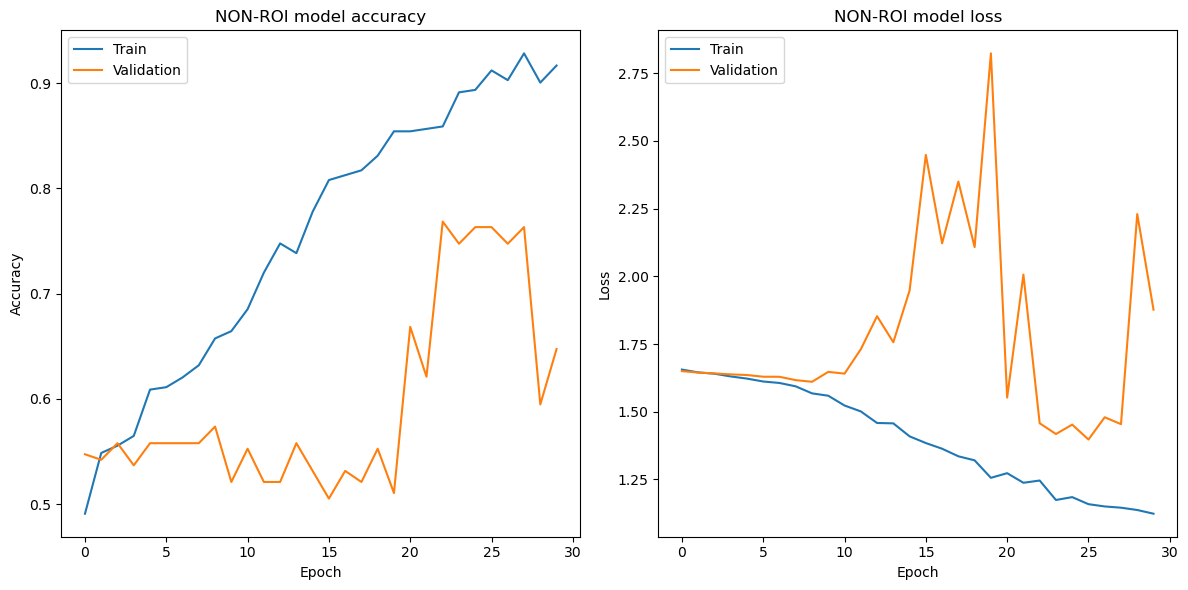

In [14]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('NON-ROI model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('NON-ROI model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig("results/nonroi_30epoch.png")

plt.tight_layout()
plt.show()

In [15]:
res = model.evaluate(
    test_dataset,
    steps = len(test_paths) // batch_size,
    verbose = 1
)

19/19 [==============================] - 127s 7s/step - loss: 1.8767 - accuracy: 0.6474 - recall: 0.6474 - auc: 0.7236 - precision: 0.6474


In [16]:
print(f"Testing Accuracy:{res[1]:.2f} - Loss:{res[0]:.2f} - Recall:{res[2]:.2f} - AUC:{res[3]:.2f} - Precision:{res[4]:.2f}")

Testing Accuracy:0.65 - Loss:1.88 - Recall:0.65 - AUC:0.72 - Precision:0.65


In [17]:
y_pred = model.predict(
    test_dataset,
    steps = len(test_paths) // batch_size,
    verbose = 1
)

19/19 [==============================] - 127s 7s/step


In [18]:
y_pred_arg = np.argmax(y_pred, axis=1)
y_pred_arg = y_pred_arg.tolist()

In [19]:
true_labels = []
for i in range(0, len(test_paths), batch_size):
    batch_labels = test_labels[i:i + batch_size]
    true_labels.extend(batch_labels)
    
if len(y_pred) != len(true_labels):
    true_labels = true_labels[:len(y_pred)]

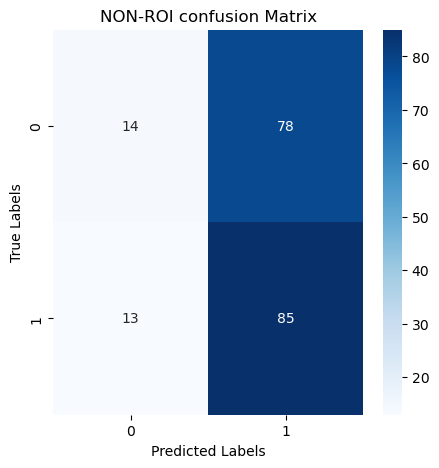

In [20]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


c_matrix = confusion_matrix(true_labels, y_pred_arg)
plt.figure(figsize=(5, 5))
sns.heatmap(c_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('NON-ROI confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.savefig("results/nonroi 30epoch confusion_matrix.png")
plt.show()